In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd


In [3]:
BATCH_SIZE = 32
IMG_HEIGHT, IMG_WIDTH = (256, 256)
input_shape = (IMG_HEIGHT, IMG_WIDTH, 3)

In [5]:

trainDf= tf.keras.utils.image_dataset_from_directory(
   "DataSets/deeplproj-grapes/train",
    labels='inferred',
    shuffle= True,
    batch_size= BATCH_SIZE,
    image_size= (256,256)
)

testDf= tf.keras.utils.image_dataset_from_directory(
   "DataSets/deeplproj-grapes/test",
    labels='inferred',
    shuffle= True,
    batch_size= BATCH_SIZE,
    image_size= (256,256)
)

validationDf= tf.keras.utils.image_dataset_from_directory(
   "DataSets/deeplproj-grapes/validation",
    labels='inferred',
    shuffle= True,
    batch_size= BATCH_SIZE,
    image_size= (256,256)
)


Found 2927 files belonging to 4 classes.
Found 405 files belonging to 4 classes.
Found 730 files belonging to 4 classes.


In [44]:
class_names=testDf.class_names
class_names

['black rot',
 'esca (black measles)',
 'healthy',
 'leaf blight (isariopsis leaf spot)']

In [7]:
len(validationDf)

23

In [8]:
class_names_trainDf= trainDf.class_names
class_names_testDf= testDf.class_names
class_names_validationDf=validationDf.class_names

In [10]:
for image_batch, label_batch in trainDf.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 2 0 3 1 1 3 1 1 1 1 3 0 2 1 1 1 0 2 1 3 1 2 1 1 3 1 0 1 3 3 0]


2023-12-26 18:04:55.403971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2927]
	 [[{{node Placeholder/_4}}]]
2023-12-26 18:04:55.404792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2927]
	 [[{{node Placeholder/_4}}]]


2023-12-26 18:04:57.891812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2927]
	 [[{{node Placeholder/_4}}]]
2023-12-26 18:04:57.892576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2927]
	 [[{{node Placeholder/_4}}]]


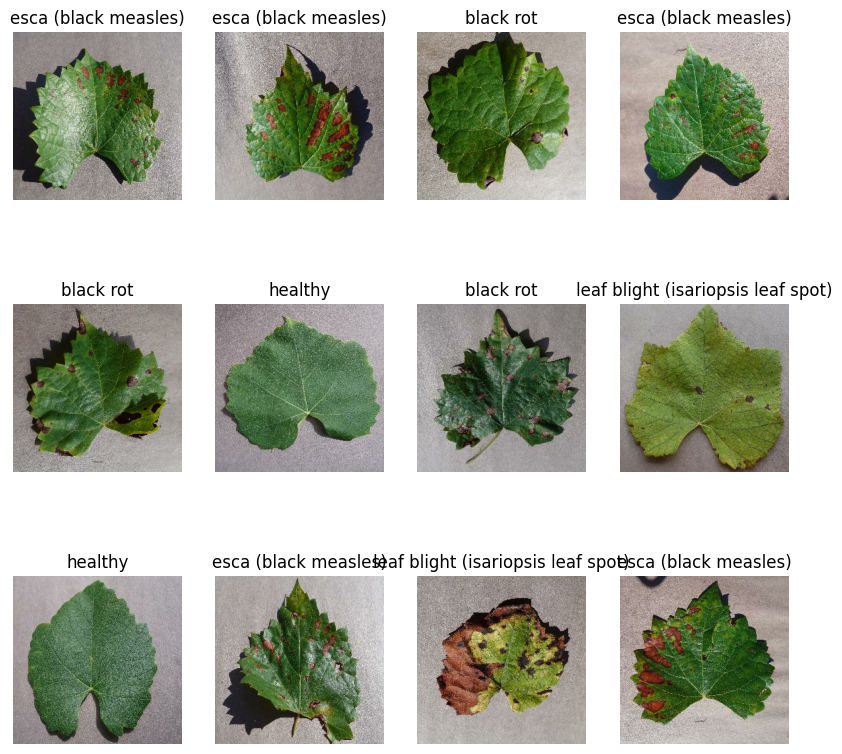

In [11]:
#plot some images from the train dataset 
plt.figure(figsize=(10,10))
for image_batch, label_batch in trainDf.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names_trainDf[label_batch[i]])
        plt.axis('off')


In [12]:
#optimize the datasets for training performance
train_ds= trainDf.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= testDf.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validate_ds= validationDf.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [13]:
rezise_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMG_HEIGHT, IMG_WIDTH),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [14]:

data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [15]:
#Now we start wiht CNN use
from tensorflow.keras.layers import Input

IMAGE_SIZE = (256,256, 3)
n_classes = 13

model= models.Sequential([
    Input(shape=IMAGE_SIZE),
    rezise_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3) ,activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=IMAGE_SIZE)

In [16]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [17]:
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [18]:
steps_per_epoch= len(train_ds)
validation_steps = len(validate_ds)

history = model.fit(
    train_ds,
    epochs = 40,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = validate_ds,
    workers=4,
    steps_per_epoch= steps_per_epoch,
    validation_steps= validation_steps,
    use_multiprocessing= True,
)

Epoch 1/40


2023-12-26 18:05:12.025203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2927]
	 [[{{node Placeholder/_4}}]]
2023-12-26 18:05:12.026571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2927]
	 [[{{node Placeholder/_4}}]]
2023-12-26 18:05:15.374188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-12-26 18:05:17.264216: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f1cef189700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
202

92/92 [==============================] - ETA: 0s - loss: 1.3290 - accuracy: 0.3830

2023-12-26 18:05:32.129177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [730]
	 [[{{node Placeholder/_4}}]]
2023-12-26 18:05:32.129660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [730]
	 [[{{node Placeholder/_0}}]]


92/92 [==============================] - 22s 142ms/step - loss: 1.3290 - accuracy: 0.3830 - val_loss: 1.0776 - val_accuracy: 0.4740
Epoch 2/40
92/92 [==============================] - 10s 110ms/step - loss: 0.8028 - accuracy: 0.6597 - val_loss: 0.7776 - val_accuracy: 0.6589
Epoch 3/40
92/92 [==============================] - 10s 111ms/step - loss: 0.4288 - accuracy: 0.8247 - val_loss: 0.2994 - val_accuracy: 0.8781
Epoch 4/40
92/92 [==============================] - 10s 111ms/step - loss: 0.3404 - accuracy: 0.8644 - val_loss: 0.5420 - val_accuracy: 0.7849
Epoch 5/40
92/92 [==============================] - 10s 111ms/step - loss: 0.2841 - accuracy: 0.8917 - val_loss: 0.1990 - val_accuracy: 0.9219
Epoch 6/40
92/92 [==============================] - 10s 111ms/step - loss: 0.2311 - accuracy: 0.9153 - val_loss: 0.1861 - val_accuracy: 0.9260
Epoch 7/40
92/92 [==============================] - 10s 112ms/step - loss: 0.1902 - accuracy: 0.9293 - val_loss: 0.3903 - val_accuracy: 0.8630
Epoch 8/40

In [19]:
scores = model.evaluate(test_ds)

 1/13 [=>............................] - ETA: 2s - loss: 0.0639 - accuracy: 0.9688

2023-12-26 18:13:35.433059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]
2023-12-26 18:13:35.434104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]


13/13 [==============================] - 1s 93ms/step - loss: 0.0428 - accuracy: 0.9827


In [20]:
history.params

{'verbose': 1, 'epochs': 40, 'steps': 92}

In [21]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [22]:
len(history.history['accuracy'])

40

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss= history.history['val_loss']


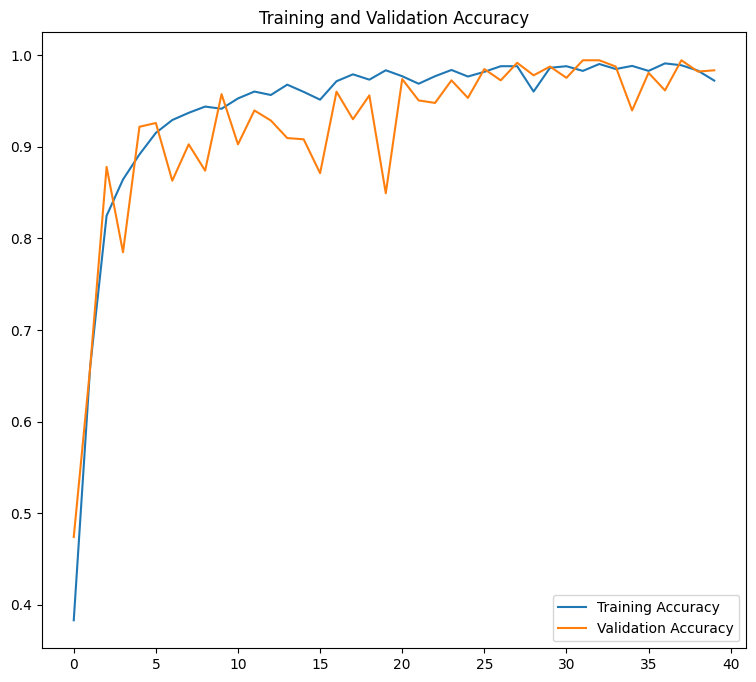

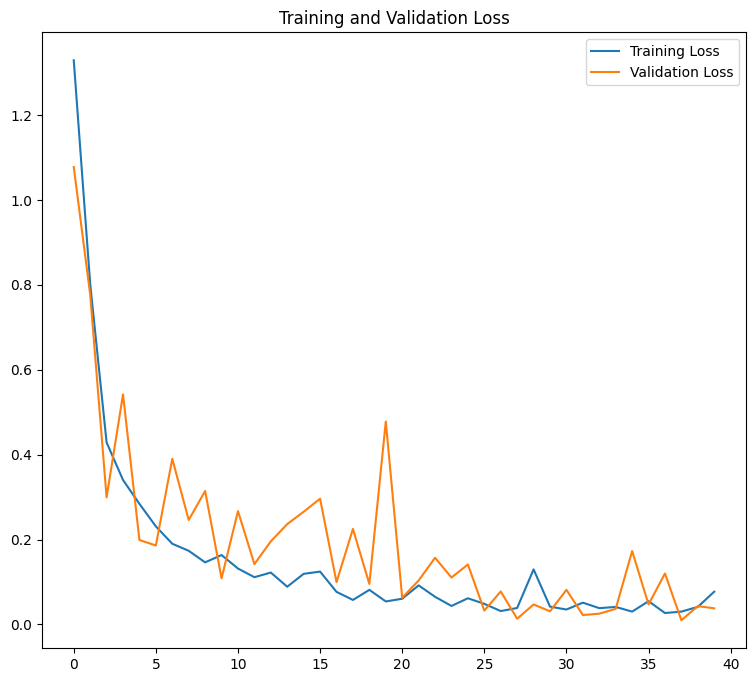

In [30]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(range(40), acc, label='Training Accuracy')
plt.plot(range(40), val_acc , label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(range(40), loss, label='Training Loss')
plt.plot(range(40), val_loss , label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to Predict
First Image actual label:  esca (black measles)
1/1 [==============================] - 0s 27ms/step


2023-12-26 18:44:16.731535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [405]
	 [[{{node Placeholder/_0}}]]
2023-12-26 18:44:16.731875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [405]
	 [[{{node Placeholder/_0}}]]


Predicted label:  esca (black measles)


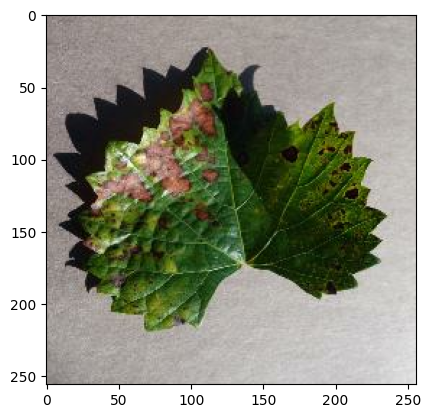

In [42]:

for image_batch, label_batch in test_ds.take(1):

    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print('First Image to Predict')
    plt.imshow(first_image)
    print('First Image actual label: ', class_names_testDf[first_label])

    batch_prediction = model.predict(image_batch)
    print('Predicted label: ', class_names_testDf[np.argmax(batch_prediction[0])])

In [45]:
#now we write a function that takes model and image as an input and tells us what is the predicted class 

def predict(model, img):

    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #creates a batch

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])), 2)

    return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


2023-12-26 19:09:26.073864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]
2023-12-26 19:09:26.074849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [405]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 16ms/step


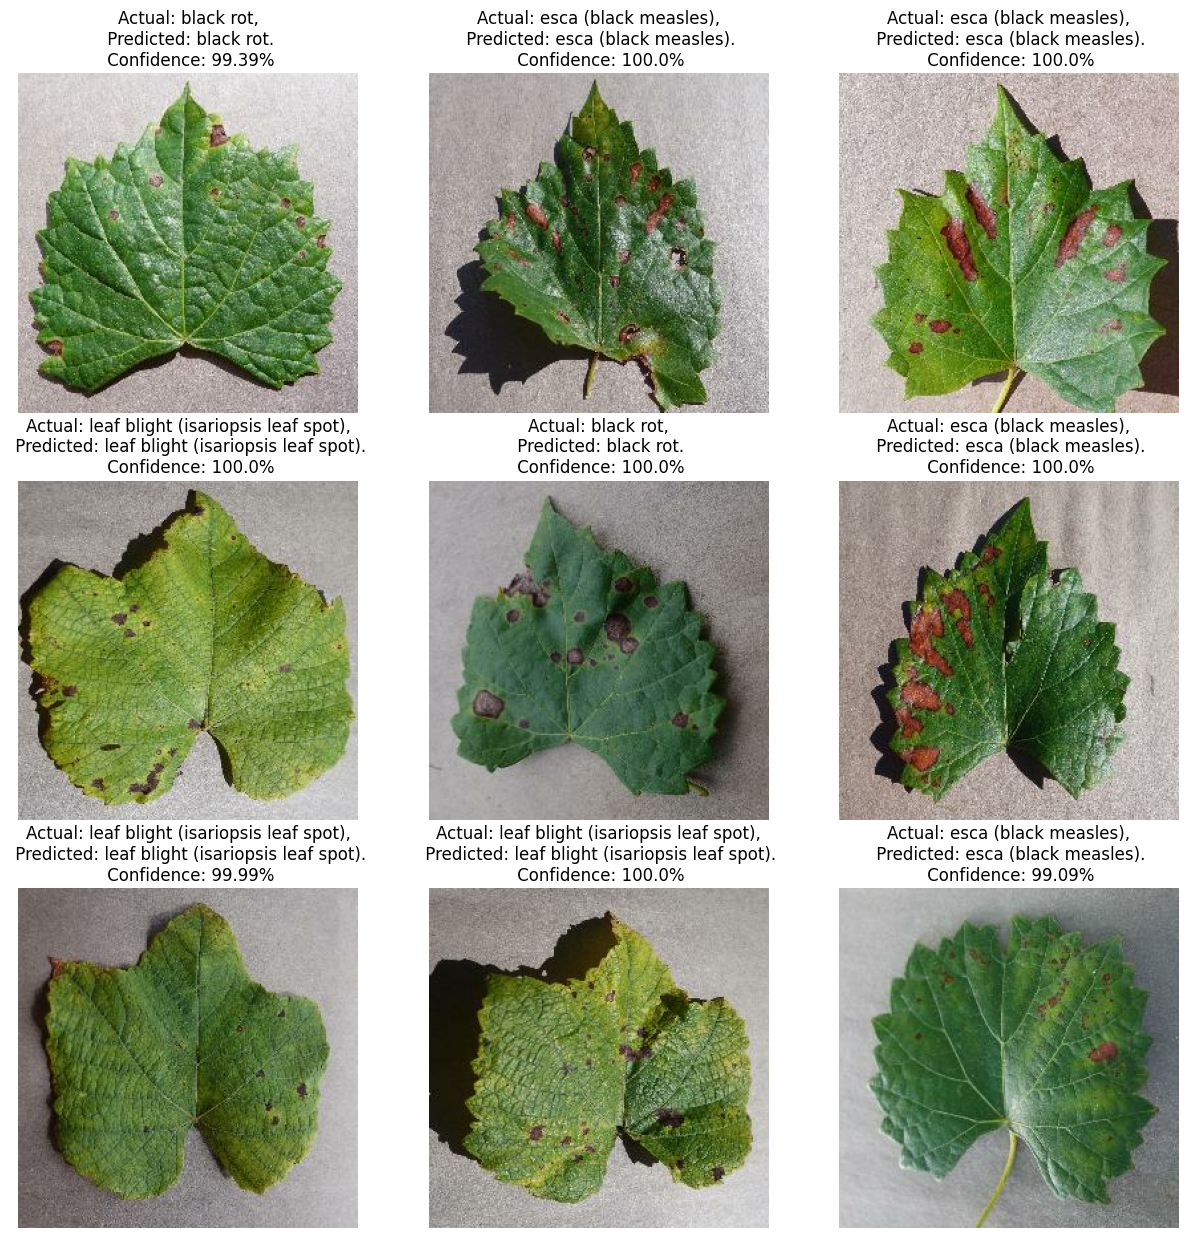

In [49]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1) 
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis('off')

In [50]:
model_version = 1
model.save(f"../Models/{model_version}")

2023-12-26 19:14:18.815230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [?,256,256,3]
	 [[{{node random_flip_input}}]]
2023-12-26 19:14:18.872444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,256,256,3]
	 [[{{node inputs}}]]
2023-12-26 19:14:18.880767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'random_flip_input' with dtype float and shape [

INFO:tensorflow:Assets written to: ../Models/1/assets


INFO:tensorflow:Assets written to: ../Models/1/assets
